# Exploratory Data Analysis

-----------------------------------------------------------------------------------

**CASE STUDY**: Impact of "Impuesto PAIS" reduction on Retail Prices


**METHODOLOGY**: Difference-in-Differences (DiD) - Parallel Trends Validation


**AUTHOR**: Belén Franco | Decision Analytics for Real-World Impact

-----------------------------------------------------------------------------------
**GOAL:**
Data Cleaning an verification of the "Parallel Trends Assumption" holds before running the causal model. This step ensures that the Treatment (Imported) and Control (National) groups shared a common trajectory prior to the tax reduction event.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
DATA_PATH = r"C:\Users\belen\Downloads\df.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,prod,origen,imported,subcategoria,categoria_producto,unidad_medida1,unidad_medida2,time,post,timeToTreat,...,max_consecutivos_sin_stock,precio,precio_cont,precio_std,price_var,price_var_cont,first_price_cont,price_variation_c,dolar_variation,_merge
0,arg_7,Argentina,0.0,Cafe molido,Cafe molido,4.000000,gr,8/29/2024,0.0,-4.0,...,NaN,15750.00,15750.00,63000.00,NaN,NaN,15750.00,0.000000,0.0,Matched (3)
1,imp_228,España,1.0,Aceitunas,Aceitunas,0.833333,gr,8/29/2024,0.0,-4.0,...,NaN,10650.00,10650.00,8875.00,NaN,NaN,10650.00,0.000000,0.0,Matched (3)
2,imp_114,Italia,1.0,Pastas largas,Pastas largas,1.000000,gr,8/29/2024,0.0,-4.0,...,NaN,10674.15,10674.15,10674.15,NaN,NaN,10674.15,-0.000004,0.0,Matched (3)
3,arg_150,Argentina,0.0,Aceitunas,Aceitunas,2.500000,gr,8/29/2024,0.0,-4.0,...,NaN,1450.00,1450.00,3625.00,NaN,NaN,1450.00,0.000000,0.0,Matched (3)
4,arg_99,Argentina,0.0,Aderezos,Aderezos,1.000000,gr,8/29/2024,0.0,-4.0,...,NaN,2550.00,2550.00,2550.00,NaN,NaN,2550.00,0.000000,0.0,Matched (3)


## Data Cleaning & Formatting

In [9]:
df.shape[0]

15800

In [10]:
#Check for missing values
df.isna().sum(axis=0)

prod                             12
origen                           12
imported                         12
subcategoria                     12
categoria_producto               12
unidad_medida1                   12
unidad_medida2                   12
time                              0
post                             12
timeToTreat                      12
post_imported                    12
stock                            15
max_consecutivos_sin_stock    11016
precio                         1876
precio_cont                      12
precio_std                       12
price_var                      2339
price_var_cont                  392
first_price_cont                 12
price_variation_c                12
dolar_variation                   0
_merge                            0
dtype: int64

**Column Selection for Causal Inference**
These variables were selected to isolate the impact of the "Impuesto PAIS" and control for market noise in a retail environment:

- *prod*: Product ID (SKU). Unique identifier used to track price evolution across the panel.

- *origen*: Country of Origin. Used to classify the source of goods and verify import status.

- *imported*: Treatment Dummy (1: Imported, 0: National). Defines our Treatment vs. Control groups.

- *categoria_producto*: Product Category. Essential for segmenting the analysis and validating the Parallel Trends Assumption.

- *time*: Timestamp. The date of each price observation to capture temporal changes.

- *post*: Post-Event Dummy (1: After tax reduction, 0: Before). Indicates the period after the policy change.

- *timeToTreat*: Relative Time. Number of days relative to the event date (Day 0). Used for plotting dynamic trends.

- *precio_std*: Standardized Price. Normalized price value to allow comparison across products with different price points.

- *price_variation_c*: Price Variation (%). Our primary Dependent Variable (Outcome) used to measure the tax impact.

- *dolar_variation*: Control Variable. Captures USD exchange rate fluctuations to isolate tax effects from currency devaluation.

- *stock*: Stock Availability. Used to filter bias caused by supply chain issues or out-of-stock price spikes.

- *max_consecutivos_sin_stock*: Robustness Metric. Measures persistent stockouts, identifying products that might not reflect market pricing logic.

In [11]:
# Select the relevant columns for the analysis
df = df[['prod','origen','imported','categoria_producto','time','post','timeToTreat','precio_std','price_variation_c','dolar_variation','stock','max_consecutivos_sin_stock']]

In [12]:
# Convert dates to datetime format
df['time'] = pd.to_datetime(df['time'])

# Delete rows  with missing values in critical fields
df = df.dropna(subset=['precio_std', 'imported', 'post','time'])

# Fill missing values with 0 for the number of consecutive days without stock
df['max_consecutivos_sin_stock']=df['max_consecutivos_sin_stock'].fillna(0)
df['stock']=df['stock'].fillna(0)

# Check null values again
df.isna().sum(axis=0)

prod                          0
origen                        0
imported                      0
categoria_producto            0
time                          0
post                          0
timeToTreat                   0
precio_std                    0
price_variation_c             0
dolar_variation               0
stock                         0
max_consecutivos_sin_stock    0
dtype: int64

In [13]:
# Summary Initial Statistics
df.describe()

,imported,time,post,timeToTreat,precio_std,price_variation_c,dolar_variation,max_consecutivos_sin_stock
count,15788.000000,15788,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,0.486762,2024-09-18 11:59:05.274892288,0.904738,16.499367,11740.011362,0.750648,1.359796,4.688751
min,0.000000,2024-08-29 00:00:00,0.000000,-4.000000,21.500000,-33.333332,0.000000,0.000000
25%,0.000000,2024-09-08 00:00:00,1.000000,6.000000,1556.250000,0.000000,0.670103,0.000000
50%,0.000000,2024-09-18 12:00:00,1.000000,16.500000,4967.222150,0.000000,1.314433,0.000000
75%,1.000000,2024-09-29 00:00:00,1.000000,27.000000,10666.666000,0.000000,2.010309,4.000000
max,1.000000,2024-10-09 00:00:00,1.000000,37.000000,137487.500000,60.937500,2.628866,41.000000
std,0.499841,NaN,0.293586,12.121221,19885.422566,5.653363,0.785149,9.789656



**Statistics & Data Context**

- *TimeToTreat*: This variable represents the time horizon relative to the event (ranging from 4 days before to 37 days after the reduction).

- *Price Variation*: We observed a high standard deviation (19,885) in the price data. Due to this high variance and the potential for skewed distributions, we applied a logarithmic transformation to the dependent variable.
- *stock_dummy*: Dummy variable created to signalize when there is stock_dummy=1 or when not stock_dummy=0

In [14]:
df['log_precio'] = np.log(df['precio_std'] + 1)
df

,prod,origen,imported,categoria_producto,time,post,timeToTreat,precio_std,price_variation_c,dolar_variation,stock,max_consecutivos_sin_stock,log_precio
0,arg_7,Argentina,0.0,Cafe molido,2024-08-29,0.0,-4.0,63000.0000,0.000000,0.000000,InStock,0.0,11.050906
1,imp_228,España,1.0,Aceitunas,2024-08-29,0.0,-4.0,8875.0000,0.000000,0.000000,InStock,0.0,9.091106
2,imp_114,Italia,1.0,Pastas largas,2024-08-29,0.0,-4.0,10674.1500,-0.000004,0.000000,InStock,0.0,9.275674
3,arg_150,Argentina,0.0,Aceitunas,2024-08-29,0.0,-4.0,3625.0000,0.000000,0.000000,InStock,0.0,8.195885
4,arg_99,Argentina,0.0,Aderezos,2024-08-29,0.0,-4.0,2550.0000,0.000000,0.000000,InStock,0.0,7.844241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15783,imp_185,Brasil,1.0,Salsa de tomate,2024-10-09,1.0,37.0,8000.0000,0.000000,2.628866,InStock,0.0,8.987322
15784,arg_97,Argentina,0.0,Aderezos,2024-10-09,1.0,37.0,2005.2632,8.115778,2.628866,InStock,0.0,7.604029
15785,imp_67,España,1.0,Galletitas,2024-10-09,1.0,37.0,3350.0000,0.000000,2.628866,InStock,5.0,8.117014
15786,arg_42,Argentina,0.0,Pastas cortas,2024-10-09,1.0,37.0,2333.3333,3.703704,2.628866,InStock,0.0,7.755482


In [15]:
df['stock_dummy']=(df['stock']=='InStock').astype(int)
df

,prod,origen,imported,categoria_producto,time,post,timeToTreat,precio_std,price_variation_c,dolar_variation,stock,max_consecutivos_sin_stock,log_precio,stock_dummy
0,arg_7,Argentina,0.0,Cafe molido,2024-08-29,0.0,-4.0,63000.0000,0.000000,0.000000,InStock,0.0,11.050906,1
1,imp_228,España,1.0,Aceitunas,2024-08-29,0.0,-4.0,8875.0000,0.000000,0.000000,InStock,0.0,9.091106,1
2,imp_114,Italia,1.0,Pastas largas,2024-08-29,0.0,-4.0,10674.1500,-0.000004,0.000000,InStock,0.0,9.275674,1
3,arg_150,Argentina,0.0,Aceitunas,2024-08-29,0.0,-4.0,3625.0000,0.000000,0.000000,InStock,0.0,8.195885,1
4,arg_99,Argentina,0.0,Aderezos,2024-08-29,0.0,-4.0,2550.0000,0.000000,0.000000,InStock,0.0,7.844241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15783,imp_185,Brasil,1.0,Salsa de tomate,2024-10-09,1.0,37.0,8000.0000,0.000000,2.628866,InStock,0.0,8.987322,1
15784,arg_97,Argentina,0.0,Aderezos,2024-10-09,1.0,37.0,2005.2632,8.115778,2.628866,InStock,0.0,7.604029,1
15785,imp_67,España,1.0,Galletitas,2024-10-09,1.0,37.0,3350.0000,0.000000,2.628866,InStock,5.0,8.117014,1
15786,arg_42,Argentina,0.0,Pastas cortas,2024-10-09,1.0,37.0,2333.3333,3.703704,2.628866,InStock,0.0,7.755482,1


In [16]:
# Check unique values by column
df.nunique()

prod                          376
origen                         20
imported                        2
categoria_producto             26
time                           42
post                            2
timeToTreat                    42
precio_std                    381
price_variation_c             121
dolar_variation                25
stock                           3
max_consecutivos_sin_stock     35
log_precio                    381
stock_dummy                     2
dtype: int64

In [17]:
# Observations by product category 
df[['categoria_producto']].value_counts().reset_index()

,categoria_producto,count
0,Chocolate,1637
1,Capsulas de cafe,1134
2,Aderezos,1050
3,Pastas cortas,1050
4,Queso,881
5,Arroz,798
6,Te,798
7,Salsa de tomate,798
8,Cafe molido,798
9,Pastas largas,797


In [18]:
#Observations by product category and imported status, this chec if there are unrepresented categories
df[['categoria_producto','imported']].groupby(by=['categoria_producto','imported']).value_counts().reset_index().sort_values(by='categoria_producto',ascending=True)

,categoria_producto,imported,count
0,Aceite,0.0,251
1,Aceite,1.0,42
2,Aceitunas,0.0,294
3,Aceitunas,1.0,294
4,Aderezos,0.0,462
5,Aderezos,1.0,588
6,Arroz,0.0,546
7,Arroz,1.0,252
8,Bebidas vegetales,0.0,42
9,Bebidas vegetales,1.0,42


## Parallel Trends Assumption

Initially the Parallel Trends Assumption is violated, but this analysis consider all the products categories (the lines aren't parallel before the event) so I repeat the analysis by product category. In the Parallel *Trends Assumption - By Product Categories* it's observed that only 2 products categories violates the assumption, so I remove them from the observations and check again.

**Parallel Trends Assumption - All Product Categories**

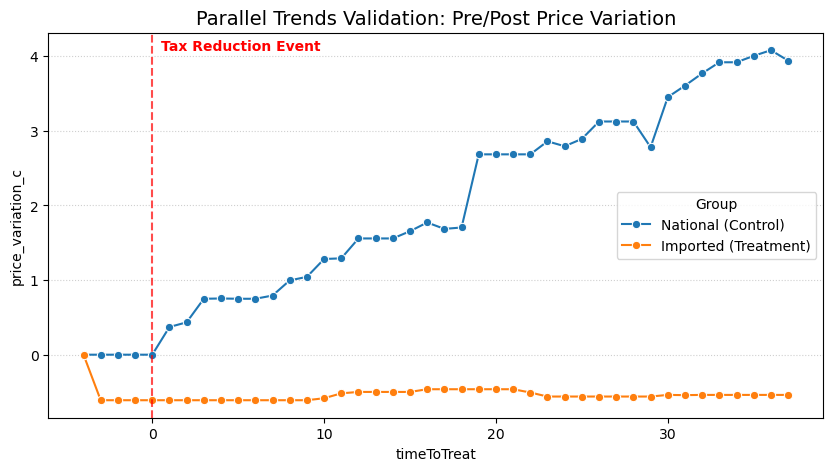

In [22]:
df_grouped = df.groupby(['timeToTreat', 'imported'])['price_variation_c'].mean().reset_index()
df_grouped['Group'] = df_grouped['imported'].map({1.0: 'Imported (Treatment)', 0.0: 'National (Control)'})

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped, x='timeToTreat', y='price_variation_c', hue='Group', marker='o')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.text(0.5, df_grouped['price_variation_c'].max(), 'Tax Reduction Event', color='red', fontweight='bold')

plt.title('Parallel Trends Validation: Pre/Post Price Variation', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

**Parallel Trends Assumption - By Product Category**

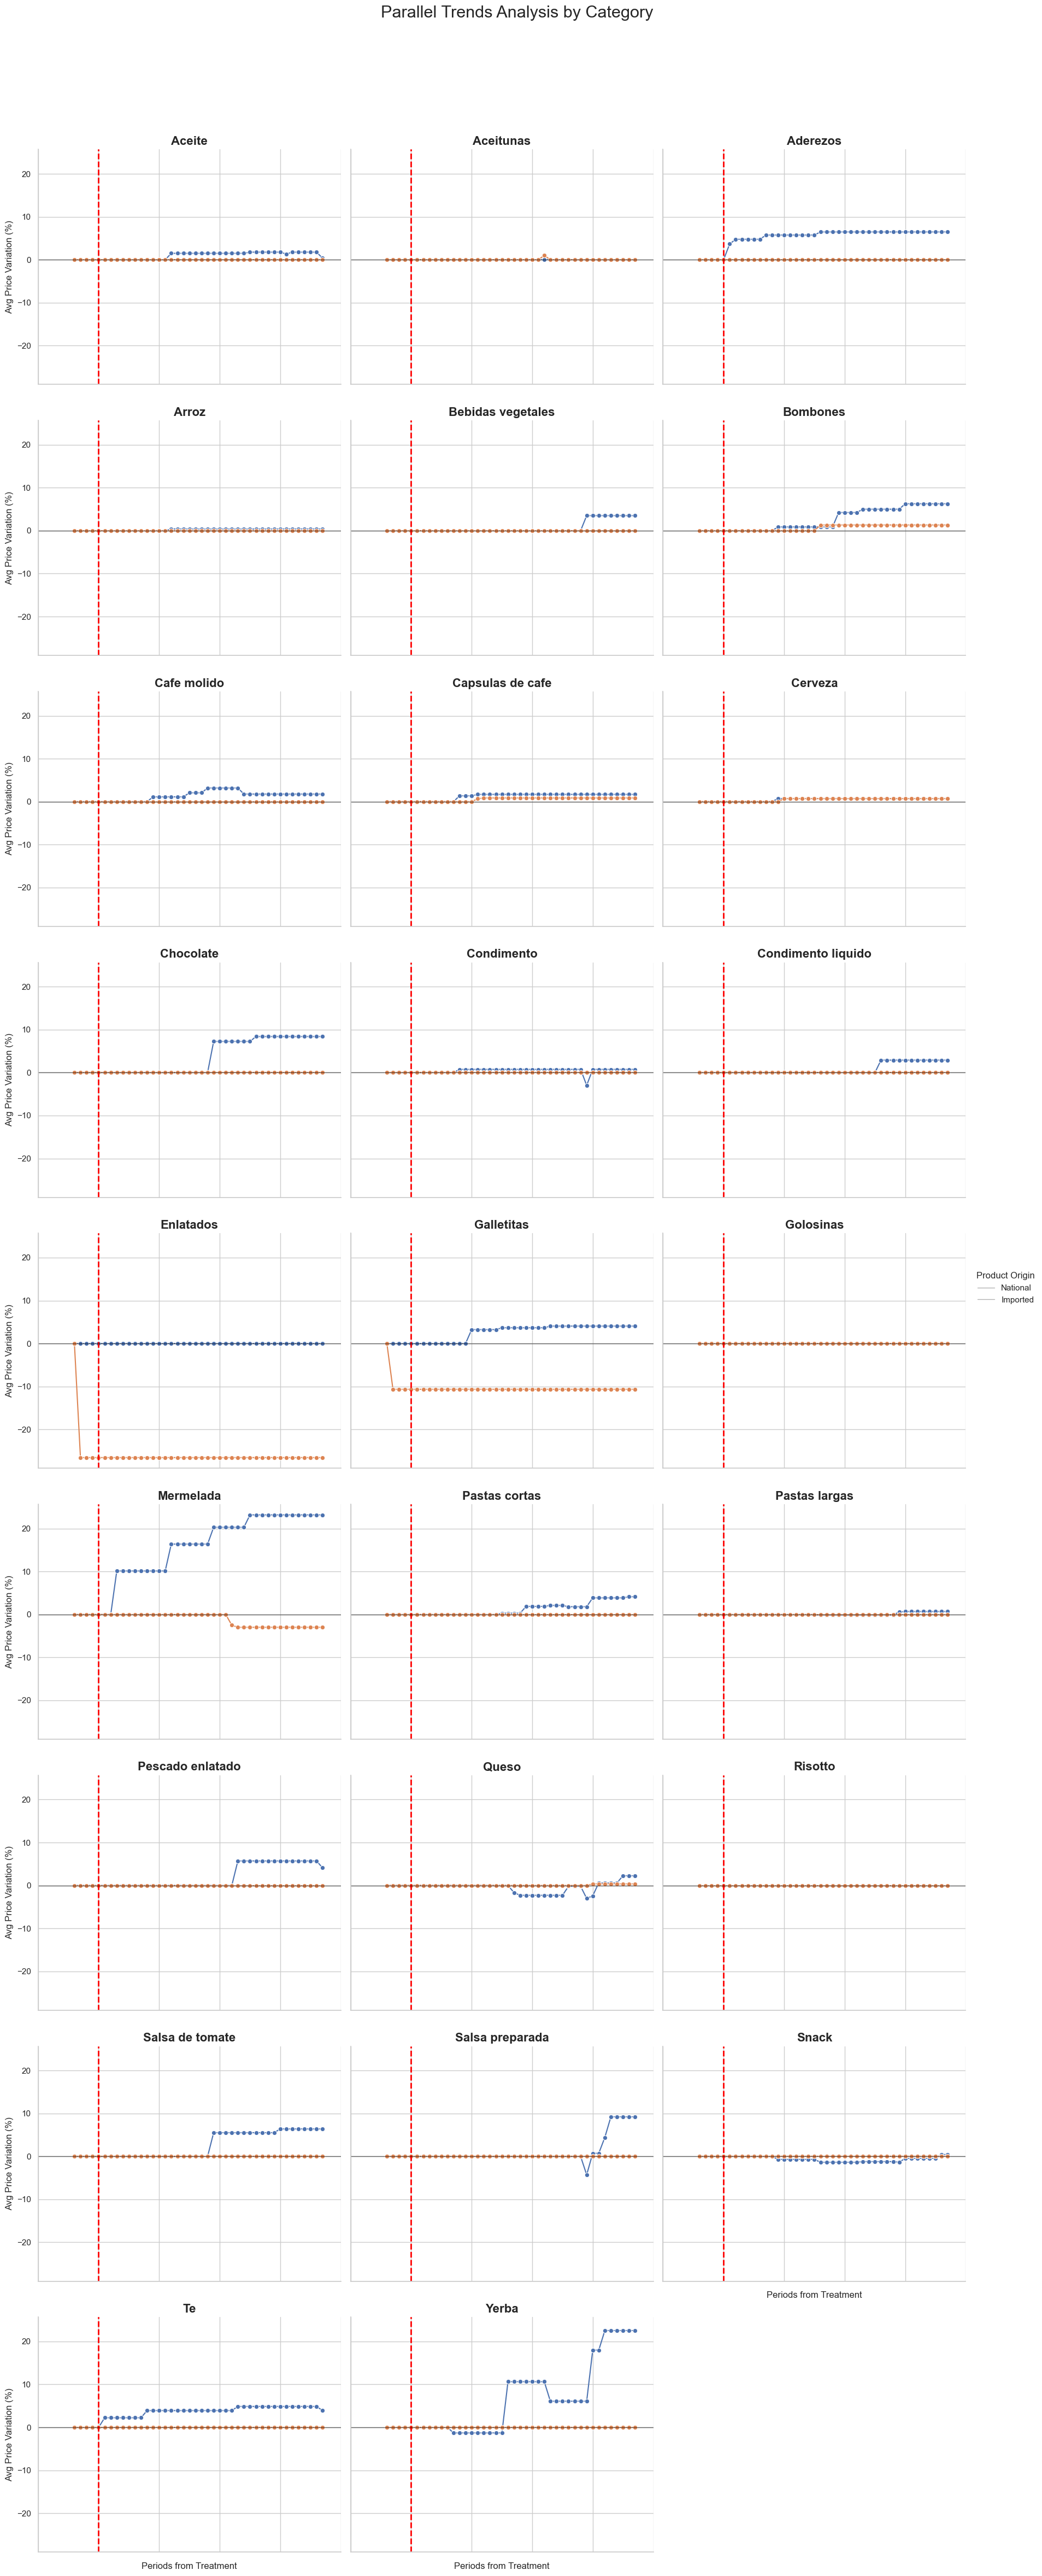

In [ ]:
df_grouped_cat = df.groupby(['timeToTreat', 'imported', 'categoria_producto'])['price_variation_c'].mean().reset_index()

# Prepare the data for plotting
plot_df = df_grouped_cat.copy()
plot_df['Group'] = plot_df['imported'].map({1: 'Imported', 0: 'National'})
sns.set_theme(style="whitegrid")

# Create the FacetGrid
g = sns.FacetGrid(
    plot_df, 
    col='categoria_producto', 
    hue='Group', 
    col_wrap=3, 
    height=5, 
    aspect=1.2,
    sharey=True 
)

# Map the lineplot
g.map(sns.lineplot, 'timeToTreat', 'price_variation_c', marker='o')
g.map(plt.axvline, x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
g.map(plt.axhline, y=0, color='black', alpha=0.3, linewidth=1)

# Formatting 
g.set_titles(col_template="{col_name}", size=16, weight='bold')
g.set_axis_labels("Periods from Treatment", "Avg Price Variation (%)")
g.add_legend(title="Product Origin")
g.set_xticklabels(rotation=45)
g.fig.suptitle('Parallel Trends Analysis by Category', fontsize=22, y=1.05)

plt.show()

In [26]:
# Remove categories that violates parallel trends assumption
df_filtered = df[(df['categoria_producto']!="Enlatados") & (df['categoria_producto']!="Galletitas")]
df_filtered

,prod,origen,imported,categoria_producto,time,post,timeToTreat,precio_std,price_variation_c,dolar_variation,stock,max_consecutivos_sin_stock,log_precio,stock_dummy
0,arg_7,Argentina,0.0,Cafe molido,2024-08-29,0.0,-4.0,63000.0000,0.000000,0.000000,InStock,0.0,11.050906,1
1,imp_228,España,1.0,Aceitunas,2024-08-29,0.0,-4.0,8875.0000,0.000000,0.000000,InStock,0.0,9.091106,1
2,imp_114,Italia,1.0,Pastas largas,2024-08-29,0.0,-4.0,10674.1500,-0.000004,0.000000,InStock,0.0,9.275674,1
3,arg_150,Argentina,0.0,Aceitunas,2024-08-29,0.0,-4.0,3625.0000,0.000000,0.000000,InStock,0.0,8.195885,1
4,arg_99,Argentina,0.0,Aderezos,2024-08-29,0.0,-4.0,2550.0000,0.000000,0.000000,InStock,0.0,7.844241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15782,imp_62,Italia,1.0,Capsulas de cafe,2024-10-09,1.0,37.0,950.0000,0.000000,2.628866,OutOfStock,39.0,6.857514,0
15783,imp_185,Brasil,1.0,Salsa de tomate,2024-10-09,1.0,37.0,8000.0000,0.000000,2.628866,InStock,0.0,8.987322,1
15784,arg_97,Argentina,0.0,Aderezos,2024-10-09,1.0,37.0,2005.2632,8.115778,2.628866,InStock,0.0,7.604029,1
15786,arg_42,Argentina,0.0,Pastas cortas,2024-10-09,1.0,37.0,2333.3333,3.703704,2.628866,InStock,0.0,7.755482,1


**Parallel Trends Assumption - Selected Product Categories**

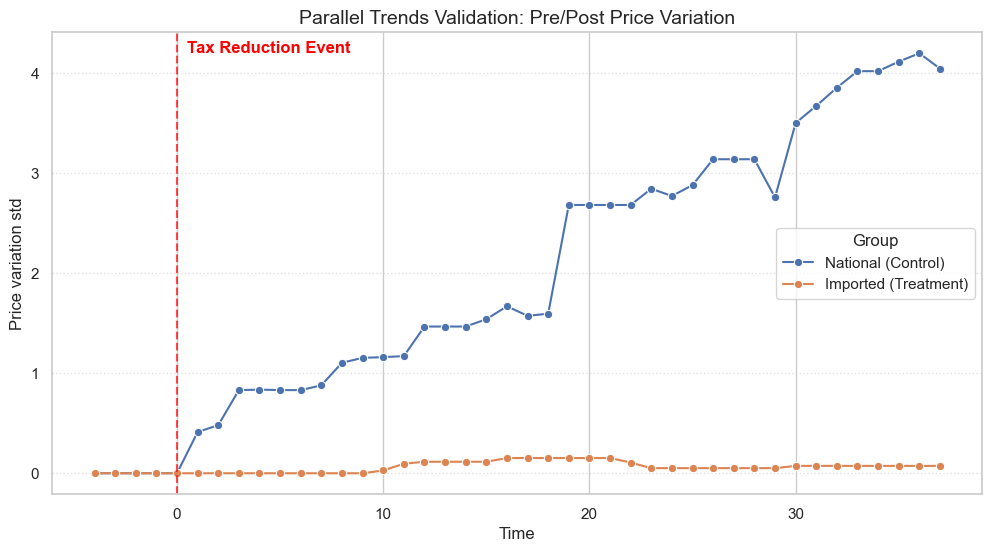

In [27]:
df_grouped = df_filtered.groupby(['timeToTreat', 'imported'])['price_variation_c'].mean().reset_index()
df_grouped['Group'] = df_grouped['imported'].map({1.0: 'Imported (Treatment)', 0.0: 'National (Control)'})

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='timeToTreat', y='price_variation_c', hue='Group', marker='o')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.text(0.5, df_grouped['price_variation_c'].max(), 'Tax Reduction Event', color='red', fontweight='bold')
plt.title('Parallel Trends Validation: Pre/Post Price Variation', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price variation std')
plt.show()

In [53]:
df.to_csv('df_clean.csv', index=False)